# モデルの学習曲線

In [48]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [49]:
import datetime
import os
import pathlib

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates
from scipy.interpolate import make_smoothing_spline

from funcs.ios import get_excel_sheet
from funcs.tse import get_ticker_name_list

In [50]:
# ソースファイル
date_str = "20250819"
path_excel = f"../excel/tick_{date_str}.xlsx"
code = "7011"
name = get_ticker_name_list([code])[code]
print(code, name)
excel_file = str(pathlib.Path(path_excel).resolve())
df_tick = get_excel_sheet(excel_file, code)
df_tick.index = [
    pd.to_datetime(str(datetime.datetime.fromtimestamp(t))) for t in df_tick["Time"]
]
print(df_tick.head())

7011 三菱重工業
                                    Time  Price   Volume
2025-08-19 09:01:15.496406  1.755562e+09   4025  1213700
2025-08-19 09:01:17.326403  1.755562e+09   4030  1827900
2025-08-19 09:01:17.515900  1.755562e+09   4030  1827900
2025-08-19 09:01:18.532149  1.755562e+09   4030  1827900
2025-08-19 09:01:19.536610  1.755562e+09   4033  1888700


## ティックデータ

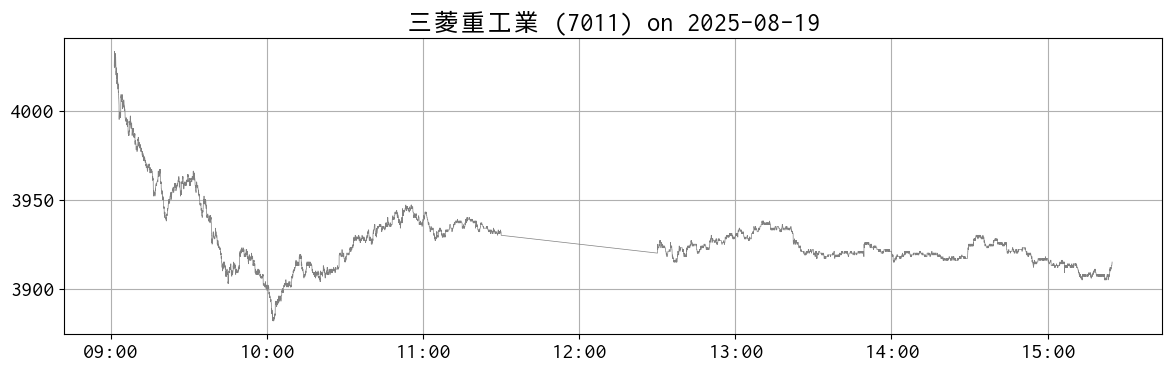

In [51]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df_tick["Price"], color="gray", linewidth=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.grid()

ax.set_title(f"{name} ({code}) on {df_tick.index[0].strftime('%Y-%m-%d')}")

plt.tight_layout()
plt.savefig(f"screenshots/tick_{code}_{date_str}.png")
plt.show()

## 学習曲線

In [52]:
path_csv = "../modules/training_history_7011_20250819.csv"
csv_file = str(pathlib.Path(path_csv).resolve())
df_csv = pd.read_csv(csv_file)
df_csv

,epoch,episode_reward,pnl_total,approx_kl,clipfrac
0,1,-1.843334e+06,0.0,0.342180,0.439327
1,2,-1.845601e+06,0.0,0.022097,0.034962
2,3,-1.827077e+06,-26.0,0.000214,0.010749
3,4,-1.787307e+06,5.0,0.000094,0.017992
4,5,-1.807619e+06,-16.0,0.000256,0.015360
...,...,...,...,...,...
995,996,3.355086e+01,105.0,0.001842,0.095841
996,997,-1.335982e+01,52.0,0.001112,0.121151
997,998,-2.056505e+01,53.0,0.000837,0.093803
998,999,-5.536415e+01,10.0,0.001322,0.092579


In [53]:
spl = make_smoothing_spline(df_csv["epoch"], df_csv["pnl_total"])
xs = np.linspace(0, len(df_csv) - 1, 1000)

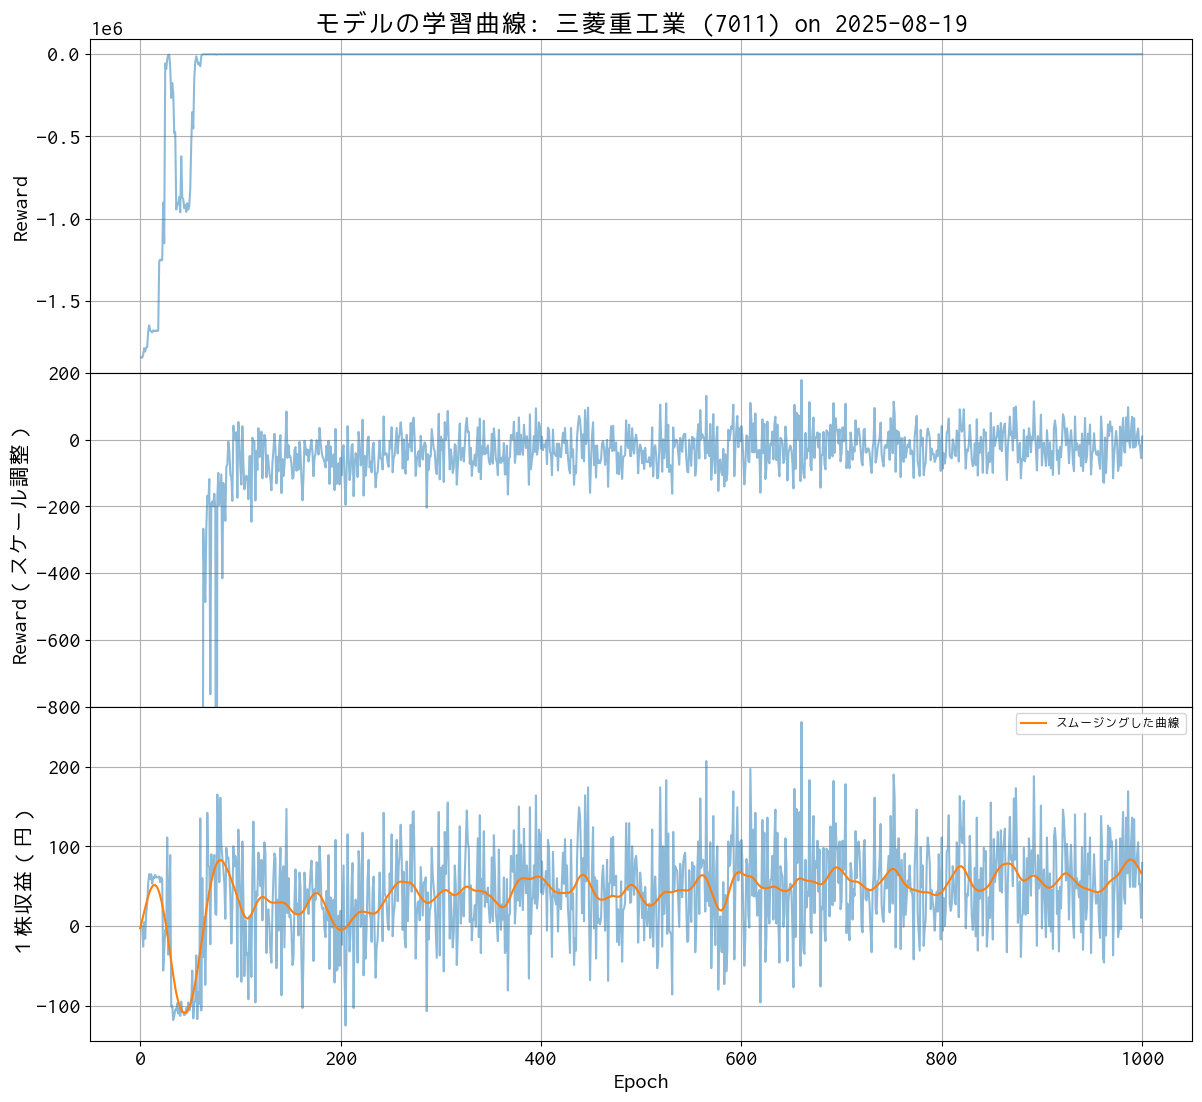

In [54]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

ax = dict()
n = 3

if n > 1:
    fig = plt.figure(figsize=(12, 11))
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
else:
    fig, ax[0] = plt.subplots(figsize=(12, 4))

ax[0].set_title(f"モデルの学習曲線: {name} ({code}) on {df_tick.index[0].strftime('%Y-%m-%d')}")
ax[0].plot(df_csv["epoch"], df_csv["episode_reward"], alpha=0.5)
ax[0].grid()
ax[0].set_ylabel("Reward")

ax[1].plot(df_csv["epoch"], df_csv["episode_reward"], alpha=0.5)
ax[1].grid()
ax[1].set_ylabel("Reward（スケール調整）")
ax[1].set_ylim(-800, 200)

ax[2].plot(df_csv["epoch"], df_csv["pnl_total"], alpha=0.5)
ax[2].plot(xs, spl(xs), label="スムージングした曲線")
ax[2].grid()

ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("１株収益（円）")
ax[2].legend(fontsize=9)

plt.tight_layout(pad=0.4, rect=[0, 0, 1.0, 1.0])
#plt.savefig(imgname)
plt.savefig(f"screenshots/learning_curve_{code}_{date_str}.png")
plt.show()